## Intro to Data Analysis Project: Investigate a Dataset 
### Titanic Data

#### Prepared by:
Jeff Daniels  
jeffrey.arthur.daniels@gmail.com  
23 August 2017

### Background:

The data I will be analyzing is the Kaggle "Titanic: Machine Learning from Disaster" training set.  This data describes the passengers travelling on the Titanic when it sunk.  Let us load the data and take a quick look at it.

In [39]:
# Load the Data and get familiar with it
# Source: https://www.kaggle.com/c/titanic/data
# Refer to the Kaggle website for Variable Descriptions
# Note that for this Udacity project, the train.csv data is used and has been renamed 'titanic-data.csv'

import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

data = pd.read_csv('../input/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The Kaggle [website](https://www.kaggle.com/c/titanic/data) for this data has excellent descriptions of variables in this data so I will not go into great detail about what each variable is.  This data which lists a sample of the ship population could be used to estimate and describe the rest of the ship population.  If I had additional data, I could describe this sample in terms of world or national populations at the time and compare Titanic passengers to the population that stayed on land during the ship's voyage.  Instead I shall take inspiration from the Kaggle competition that tried to predict which passengers survived and which perished and examine which variables correlated with survival the most.  Therefore, the dependent variable which will be studied in detail is 'Survived' which is an integer where a value of 0 means the passenger perished and a value of 1 means the passenger survived.

### Questions:  
Is the expression "Women and Children First" reflected in the rates of survival for these two groups in our data set?  If the lifeboat boarding priority does follow this protocol, then women and children would survive at a higher rate than the other lifeboat boarding group: men.  Is the data consistent with behavior of the men aboard the ship offering lifeboats seats to women and children first?

Does the captain go down with the ship?

Both questions could be nautical cliches steeped in some sort of romanticism about ship disasters and courageous ways to die at sea.  Investigating whether survival correlated with these expressions should help gain insight to what kind of passengers survived the Titanic disaster.

Additionally, are there other variables that could have significantly affected survival rates in the lifeboat boarding groups?

#### Workflow stages
1. Acquire the data
2. Analyze, explore, and identify patterns in the data
3. Seperate passengers into boarding groups Women, Children, and Men and compare survival
4. Examine other variables and how they could possibly affect the "Women and Children First" protocol

### 1. Acquire the data

The data has been loaded and previewed above.  We can see that each row corresponds to a passenger.

In [40]:
# Display summary statistics quickly
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Applying the <b>describe</b> function tells us that there are 891 passengers in the sample set.  About 38% of the passengers survived.  The average age of the sample is 29.7 years old, and the median age is 28.  There are also 177 passengers that have null values values for their ages which must be addressed in order to categorize them as children or not.

The describe function also hints that not all the variables are numerical.  It only summarizes variables that are numerical so there are fewer columns listed than in a complete dataframe.  The 'Name', 'Sex', 'Ticket', 'Cabin', and 'Embarked' variables seem to be strings.  I can confirm this with the <b>info</b> function:

In [41]:
# Describe the DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Not all of the columns are numerical.  Not all rows contain entries for certain columns, 'Age', 'Cabin', or 'Embarked'.  This tells us which non-numerical data should be converted and null data substituted for.  

In [42]:
# Categorical Data Summary
data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Futrelle, Mr. Jacques Heath",male,1601,B96 B98,S
freq,1,577,7,4,644


The number of rows in the data frame is equal to the number of unique names in the 'Name' column.  This makes the 'Name' column difficult to categorize.

The 'Sex' columm will be very easy to categorize.

There are fewer unique entries in the 'Ticket' column, I assumes this means a family or a group shared a ticket.  The ticket with the most passengers was associated with 7 people.

Only 204 people stayed in cabins.  The most people in a cabin was four.    

### 2. Analyze, Explore, Identify Patterns in Data

The easiest way to find correlations in the data is to simply use the <b>corr</b> function.  This requires converting some of the features into numerical features.  Generally I will continue using the convention of the 'Survived' variable which is essentially a boolean variable represented as the integers 0 and 1.  New variables 'Female', and 'Male' will be created from the 'Sex' column.  Variables 'Pc1', 'Pc2', and 'Pc3' will represent the passenger class variable 'Pclass' and its three uniquee values: 1, 2, and 3.  Variables 'Emb_C', 'Emb_Q', and 'Emb_S' will represent the 'Embarked' column and the embarkation ports of Cherbourg, Queenstown, and Southampton respectively.

In [43]:
# Convert variables into integers
# To improve code, used dictionaries

# Create new boolean variables for sex
data['Female'] = (data['Sex']=='female').astype(int)
data['Male'] = (data['Sex']=='male').astype(int)

# Create new boolean variables for passenger class
data['Pc1'] = (data['Pclass']==1).astype(int)
data['Pc2'] = (data['Pclass']==2).astype(int)
data['Pc3'] = (data['Pclass']==3).astype(int)

# Create new numerical variables to describe embarkation ports
data['Emb_C'] = (data['Embarked']=='C').astype(int)
data['Emb_Q'] = (data['Embarked']=='Q').astype(int)
data['Emb_S'] = (data['Embarked']=='S').astype(int)

Now apply the <b>corr</b> function in terms of 'Survived':

In [44]:
(data.corr().Survived).sort_values(ascending= False)

Survived       1.000000
Female         0.543351
Pc1            0.285904
Fare           0.257307
Emb_C          0.168240
Pc2            0.093349
Parch          0.081629
Emb_Q          0.003650
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Emb_S         -0.155660
Pc3           -0.322308
Pclass        -0.338481
Male          -0.543351
Name: Survived, dtype: float64

The variable that correlated most positively to survival is 'Female'.  The most negatively correlated was 'Male'.  Clearly 'Sex' correlates well with 'Survival'.  This makes it seem very likely that women were given preferential lifeboat boarding along with female children.  The negative correlation of being male could mean that both men and male children were refused entry on lifeboats.  I can't say for sure at this point whether both female and male children boarded lifeboats at different rate than the adults.  This relationship will be studied in further detail.

The correlation between 'Age' and 'Survival' does not appear to be very strong but it is negatively correlated which means older people had lower rates of survival.  This could indicate that children had a better chance of survival but more analysis is necessary.

The variable with the next highest magnitude after those related to gender is 'Pclass' which describes passengers as either 1, 2, or 3.  What this means is that the 'Pclass' is negatively correlated with passenger class.  The higher the number of your class, the less likely you will survive.  This can be confusing because first class passengers are considered upper class and third class, lower class.  Though there does seem to be a strong linear correlation between 'Pclass' and 'Survival', I think a linear correlation is inappropriate for describing what are just three datapoints on the 'Pclass' vs. 'Survival' curve.  The 'Pclass' variable should still be treated as a categorical variable.  Splitting up 'Pclass' into three boolean variables as I have done should make this clearer.

Among the variables describing each passenger class, 'Pc3' is most negatively correlated with 'Survival' and 'Pc1' is most positively correlated.  'Pc2' is also positively correlated with survival but to a lesser degree.  The magnitudes of 'Pc3' and 'Pc1' correlations demand further analysis.

Next up, 'Fare' positively correlates with survival.  This means that the more you paid for your ticket, the greater you likelihood for survival.  I suspect however, that 'Fare' correlates strongly with 'Pclass'.  I'll study this relationship further.

### 3. Differentiate groups of passengers and compare their survival rates

#### Age and Survival  

Let us quickly examine 'Age' and 'Survival' in a histogram.  Please note that the passengers for whom 'Age' was NaN are grouped in the far right bin.  The oldest passenger with a verified age was 80-years-old.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


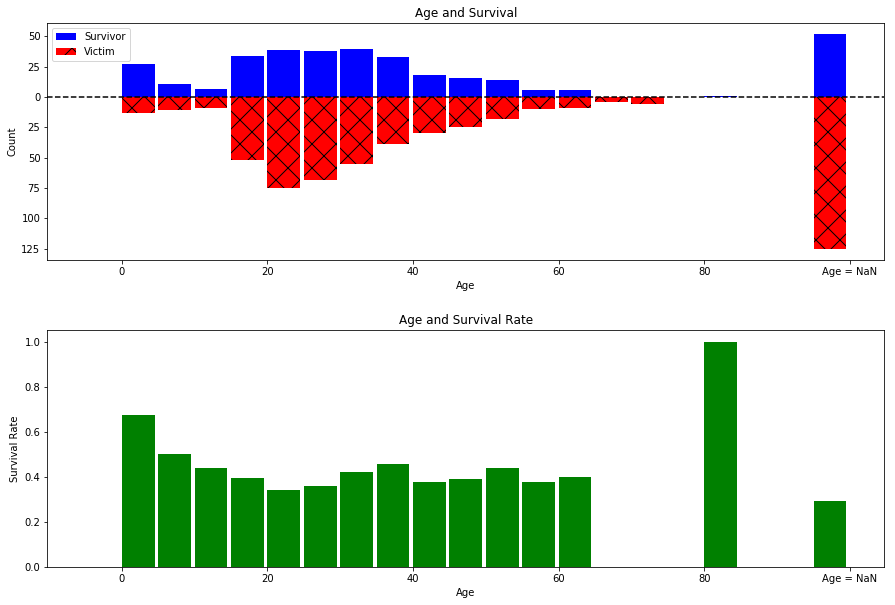

In [45]:
# Plot a frequency histogram with survivors and victims grouped by age
# Use the fillna function to differentiate those whose ages are NaN
# Set NaN to 100 which is much greater than max('Age') = 80

nan_sub = 100
survivors_age = data[data.Survived == True].Age.fillna(nan_sub)
victims_age = data[data.Survived == False].Age.fillna(nan_sub)


bin_width = 5
lower_bound = -5
upper_bound = 105
bar_width = 4.5
survivor_color = 'b'
victim_color = 'r'
rate_color = 'g'

bins = np.arange(lower_bound, upper_bound, bin_width)
index = bins[0:-1]

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (15,10))
ax1.bar(index + 0.5*bar_width, np.histogram(survivors_age, bins)[0],
       color = survivor_color, width = bar_width)
ax1.bar(index + 0.5*bar_width, np.histogram(victims_age, bins)[0]*-1,
        color = victim_color, width = bar_width, hatch = 'x')

ax1.set_ylabel('Count')
ax1.set_xlabel('Age')
ax1.set_title('Age and Survival')
ax1.legend(['Survivor', 'Victim'])
ax1.axhline(0, color = 'k', linestyle = '--')
ax1.set_xticklabels(['',0, 20, 40, 60, 80, 'Age = NaN'])
ticks =  ax1.get_yticks()
ax1.set_yticklabels([int(abs(tick)) for tick in ticks])

# Plot Age vs. Survival rate

nan_sub = 100
survivors_age = data[data.Survived == True].Age.fillna(nan_sub)
all_age = data.Age.fillna(nan_sub)
age_rate = np.nan_to_num(np.histogram(survivors_age,bins)[0]/np.histogram(all_age,bins)[0])


ax2.bar(index+0.5*bar_width, age_rate, 
        color = rate_color, width = bar_width)


ax2.set_ylabel('Survival Rate')
ax2.set_xlabel('Age')
ax2.set_title('Age and Survival Rate')
ax2.set_xticklabels(['',0, 20, 40, 60, 80, 'Age = NaN'])
plt.subplots_adjust(hspace = 0.3)
plt.show()



This histogram suggest that chidren, especially those 5-years and younger, had better rates of survival than most of the sample.  It also suggest that children travelled at a lower rate than adults since there is a discontinuity in the age distribution at around 15 years and younger.  If the sample reflected the general human population, the age of passengers should be gradually decreasing as people age and die.  This age discontinuity is also a threshold where passengers who were younger survived at higher rates than the rest of the sample.  Though this initially suggests that children had a higher survival rate, the age cutoff for children will have to be explicitly definined in order to continue our analysis.

The histogram also shows that those for whom 'Age' is NaN are a significant portion of our sample and they also have the lowest likelihood of survival.  Often missing values like this are filled in with a median or mean value from the rest of the sample but this would be reckless if our goal is to seperate adults and children.  A mean or median substitution for 'Age' equal to NaN would group them all as adults.  Alternatively, one could assign a random age to these passengers that reflects the age distribution of the rest of the sample but this could also be misleading.

I propose examining the sample closely to find some sort of other way of seperating the samples into children and adults.  For now, I will assume that children are 18-years-old or younger.

In [46]:
# Explore passengers presume to be children
age_cutoff = 18
data[data.Age<age_cutoff].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,Male,Pc1,Pc2,Pc3,Emb_C,Emb_Q,Emb_S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0,1,0,0,1,0,0,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1,0,0,1,0,1,0,0
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,1,0,0,0,1,0,0,1
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S,1,0,0,0,1,0,0,1
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q,0,1,0,0,1,0,1,0


In [47]:
# Explore passengers presumed to be adults
data[data.Age>=age_cutoff].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,Male,Pc1,Pc2,Pc3,Emb_C,Emb_Q,Emb_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,0,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,1,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,0,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,1,0,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,0,0,1,0,0,1


In [48]:
# Explore passengers whose 'Age' is NaN
data[data.Age.isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,Male,Pc1,Pc2,Pc3,Emb_C,Emb_Q,Emb_S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,1,0,0,1,0,1,0
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,0,1,0,1,0,0,0,1
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,1,0,0,0,1,1,0,0
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,0,1,0,0,1,1,0,0
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,1,0,0,0,1,0,1,0


Children tend to have the titles of "Master", and "Miss".  I would also pressume that any female with the title of "Mrs" to be married and considered an adult, though they seemed to get married a lot younger back then.  The sample contains a few passengers with the 'Title' of "Mr" and "Mrs" who are less than 18 years old.  Anyways, extracting titles from the 'Name' variable seems like a promising avenue to distinguish adults and children.  A new variable 'Title' shall be created.

In [49]:
# Create a new variable 'Title'
# extract the string that preceeds a "."
# Quickly confirm that the operation was performed properly
import re
regex = re.compile('([A-Za-z]+)\.')
data['Title'] = data.Name.str.extract(regex, expand = True)
data['Title'].describe()

count     891
unique     17
top        Mr
freq      517
Name: Title, dtype: object

Fortunately for us, every passenger in our sample has a title.  Let us compare 'Title' to 'Sex' and get an idea of what was produced.

In [50]:
# Compare 'Title' and 'Sex'
data.pivot_table('Name', index = 'Title', columns = ['Sex'], aggfunc =('count')).fillna(0)

Sex,female,male
Title,,
Capt,0.0,1.0
Col,0.0,2.0
Countess,1.0,0.0
Don,0.0,1.0
Dr,1.0,6.0
Jonkheer,0.0,1.0
Lady,1.0,0.0
Major,0.0,2.0
Master,0.0,40.0


### Survival of Captain

Now that each passenger has a title, we can determine if "The captain goes down with the ship".

In [51]:
data[data.Title == 'Capt']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,Male,Pc1,Pc2,Pc3,Emb_C,Emb_Q,Emb_S,Title
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0,B22,S,0,1,1,0,0,0,0,1,Capt


It appears he did, but I advise caution when making conclusions about one sample.

### Create Boarding Groups

I will create the new variables 'Child', 'Man', and 'Woman' which I will refer to as boarding groups.  The 'Child' variable with be true if the passenger is less than 18-years-old.  The 'Man' and 'Woman' variables with be true if the passenger is 18 years and older along and their 'Sex' corresponds to what is considered a man or woman.

In [52]:
# Define Child and Adult status by age
age_cutoff = 18
data['Child'] = (data.Age < age_cutoff).astype(int)
data['Woman'] = (data[data.Sex=='female'].Age>=age_cutoff).astype(int)
data['Man'] = (data[data.Sex=='male'].Age>=age_cutoff).astype(int)
data['Woman'] = (data['Woman']).fillna(0)
data['Man'] = (data['Man']).fillna(0)

In [53]:
# How much of the sample has been categorized?
data['Child'].sum()+data['Woman'].sum()+data['Man'].sum()

714.0

In [54]:
data.Age.isnull().sum()

177

177 passengers have 'Age' == to NaN.  Now I will try to use the 'Title' variable to determine a boarding group for passengers whose 'Age' is NaN.  All those with the 'Title' "Mrs" will be classified as 'Woman', those with "Mr", as 'Man', and those with "Master" as 'Child'.  Already, there have been some passengers whose 'Title' was either "Mr" or "Mrs" who have been classified as children because of their age.  They will not be reclassified, their 'Age' will take precedence in this categorization.

In [55]:
mask_m = (data.Age.isnull()) & (data.Title == 'Mr')
mask_w = (data.Age.isnull()) & (data.Title == 'Mrs')
mask_c = (data.Age.isnull()) & (data.Title =='Master')
data.loc[mask_m,'Man'] = 1
data.loc[mask_w, 'Woman'] =1
data.loc[mask_c, 'Child'] = 1

# How much of the sample has been categorized?
data['Child'].sum()+data['Woman'].sum()+data['Man'].sum()

854.0

140 of the 'Age' == NaN have been categorized using the 'Title' variable.  Is there any more categorization that can be performed on the 'Title' variable?  What titles remain to be categorized?

In [56]:
# What unique titles remain in our group of uncategorized passengers?
data[data.Man ==0].loc[data.Woman ==0].loc[data.Child==0].Title.unique()

array(['Miss', 'Dr'], dtype=object)

As expected, 'Miss' is among the uncategorized since they could be children or unmarried women.  Passengers whose 'Title' is 'Dr' are most likely an adults.  More generally, let us categorize anyone who doesn't have the 'Title' of 'Miss' as adults.

In [57]:
# Categorize those without the 'Title' 'Miss' as adults, either 'Man' or 'Woman'

mask_m = ((data.Man == 0) & (data.Woman == 0) & (data.Child == 0) & (data.Title != 'Miss') 
          & (data.Sex == 'male'))
mask_w = ((data.Man == 0) & (data.Woman == 0) & (data.Child == 0) & (data.Title != 'Miss') 
          & (data.Sex == 'female'))
data.loc[mask_m, 'Man'] = 1
data.loc[mask_w, 'Woman'] =1

# How much of the sample has been categorized?
data['Child'].sum()+data['Woman'].sum()+data['Man'].sum()

855.0

Now all that remain uncategorized are females with the 'Title' of "Miss".  Assuming all are unwed, if 'SibSp' is greater than 0, that means they have siblings aboard.  It is possible for adult siblings to be travelling together, but I am going to assume this is unlikely and assert that if 'SibSp' is not 0, then the passenger is a child.  Also along that line of reasoning, if 'Parch' is not 0, then the passenger has a parent aboard or has a child.  This could occur among adults and unwed mothers, but I am again going to assume this is unlikely and categorize these passengers as children.

In [58]:
# Categorize 'Miss' passengers who have SibSp or Parch greater than 0 as children
mask_c = (data.Child ==0) & (data.Woman ==0) & (data.Man ==0) & (data.SibSp > 0)
data.loc[mask_c, 'Child'] =1
mask_c = (data.Child ==0) & (data.Woman ==0) & (data.Man ==0) & (data.Parch > 0)
data.loc[mask_c, 'Child'] =1

# How much of the sample has been categorized?
data['Child'].sum()+data['Woman'].sum()+data['Man'].sum()

869.0

Now we are left with 22 passengers out of the original 177 passengers whose 'Age' was NaN.  They all have the 'Title' of "Miss".  They can all be characterized as travelling solo.  How do we decide whether they are 'Woman' or 'Child'?  Travelling solo doesn't seem like something a child should do so can we make an assumption about where to place these solo females?

In [59]:
# Are women with the 'Title' "Miss" more likely to travel solo than children with 'Title' of "Miss"
miss_child = data[data.Child == 1].loc[data.Title == 'Miss'].PassengerId.count()
# 65 children with Title Miss
solo_miss_child = (data[data.Child == 1].loc[data.Title == 'Miss'].loc[data.SibSp == 0]
                   .loc[data.Parch ==0].PassengerId.count())
# 11 of them are travelling solo most are teenagers, one is 5 years old.

miss_woman = data[data.Woman == 1].loc[data.Title == 'Miss'].PassengerId.count()
# 95 Women with the Title Miss
solo_miss_woman = (data[data.Woman == 1].loc[data.Title == 'Miss'].loc[data.SibSp == 0]
                   .loc[data.Parch ==0].PassengerId.count())
# 67 are travelling solo
(solo_miss_woman/miss_woman)/(solo_miss_child/miss_child)
# Women with title of Miss are 4.2 times more likely to travel solo than girls

4.1674641148325353

In [60]:
# Are women with the 'Title' "Miss" more likely to travel solo than those with 'Title' "Mrs"
woman = data[data.Woman == 1].PassengerId.count()
# 233 women
solo_woman = data[data.Woman ==1].loc[data.SibSp ==0].loc[data.Parch ==0].PassengerId.count()
# 93 are travelling solo
(solo_miss_woman/miss_woman)/(solo_woman/woman)
# Women with title of Miss are 1.7 times more likely to travel solo those with title of Mrs

1.6911148839841539

In [61]:
# Do men travel solo more than boys?
boy = data[data.Child == 1].loc[data.Sex == 'male'].PassengerId.count()
# 62 male children
solo_boy = (data[data.Child == 1].loc[data.Sex == 'male'].loc[data.SibSp == 0]
            .loc[data.Parch ==0].PassengerId.count())
# 12 of them are travelling solo, all have the title Mr. ages 11-17
man = data[data.Man ==1].PassengerId.count()
# 515 Men
solo_man = data[data.Man == 1].loc[data.SibSp == 0].loc[data.Parch ==0].PassengerId.count()
# 399 are travelling solo
(solo_man/man)/(solo_boy/boy)
# Men are 4 times more likely to travel solo than boys

4.0029126213592239

I feel comfortable categorizing all the passengers whose 'Age' is NaN, title 'Miss, and who are travelling solo as 'Woman'.  Obviously I run a risk of miscategorizing some girls as women, but because more passengers with the 'Title' "Miss" are adults, and they are more likely to travel solo, I feel like this is a safe generalization.  Another option would be to distribute these passengers randomly based on the probability that they are adults or children from the rest of the ship sample, but I don't think this will make the analysis more accurate.

In [62]:
# Create a mask for solo travelling Miss who are NaN old
data[data.Man ==0].loc[data.Woman ==0].loc[data.Child==0]
mask_miss_NaN = (data.Age.isnull()) & (data.Title == 'Miss') & (data.SibSp == 0) & (data.Parch ==0)

# Assign these passengers to the 'Woman' group
data.loc[mask_miss_NaN, 'Woman'] = 1

# How much of the sample has been categorized?
data['Child'].sum()+data['Woman'].sum()+data['Man'].sum()


891.0

#### Summary of steps to identify Women, Children and Men

Less than 18 years old, a child.  Otherwise a Man or Woman depending on 'Sex'  
'Title' == 'Master' then child  
'Title' == 'Mr' then man  
'Title' == 'Mrs' then woman  
If 'Title' != 'Miss', then probably an adult with a special title  
If 'Title' == 'Miss' and SibSp' > 0 then Child  
If 'Title' == 'Miss' and 'Parch' > 0 then Child  
All remaining passengers are Women  

All of the passengers fall under the boarding group categories 'Man', 'Woman', and 'Child' now.  What this boarding group categorization did was to seperate adults and children without knowing a the ages of a signicant portion of the sample.  What it did not do was assign an age to those whose 'Age' is NaN.  I could simply assign the median age of their respective boarding groups to samples whose 'Age' is NaN.  I could also distribute random ages to these samples based on the distribution of ages in their boarding groups.  Both seem like reasonable ways to wrangle the data.  However, 'Age' will not be studied at all in the rest of this analysis so I shall decline to perform this substitution.

### Survival and Boarding Group

How did sex and childhood status affect survival?  The table below sums things up.  Being a woman correlated positively with survival.  Women survived at a rate of 78% vs. 16% for men.  Children survived at a higher rate than men.  Being a child seemed to increase survival for males but decrease it for females.  As for the "Women and Children First" expression, it seems accurate with women apparently boarding the lifeboats before the children.

In [63]:
# Survival Rates of Adults and Children by Sex
data.pivot_table('Survived', index = 'Sex', columns = 'Child', aggfunc = 'mean')

Child,0,1
Sex,,
female,0.775510,0.623188
male,0.163107,0.403226


In [64]:
# Create dataframes of survivors and victims by boarding groups


survivors = data.loc[data.Child == 0].loc[data.Survived == 1].pivot_table('Survived', index = 'Sex',
                                                                          aggfunc = 'count')
survivors.loc['Children']=data.loc[data.Child == 1].loc[data.Survived == 1]['Survived'].count()
survivors = Series(survivors.values[:,0], index = ['Women', 'Men', 'Children'], name = 'Group')

victims = data.loc[data.Child == 0].loc[data.Survived == 0].pivot_table('Survived', index = 'Sex', 
                                                                        aggfunc = 'count')
victims.loc['Children']= data.loc[data.Child ==1].loc[data.Survived ==0]['Survived'].count()
victims = Series(victims.values[:,0], index = ['Women', 'Men', 'Children'], name = 'Group')

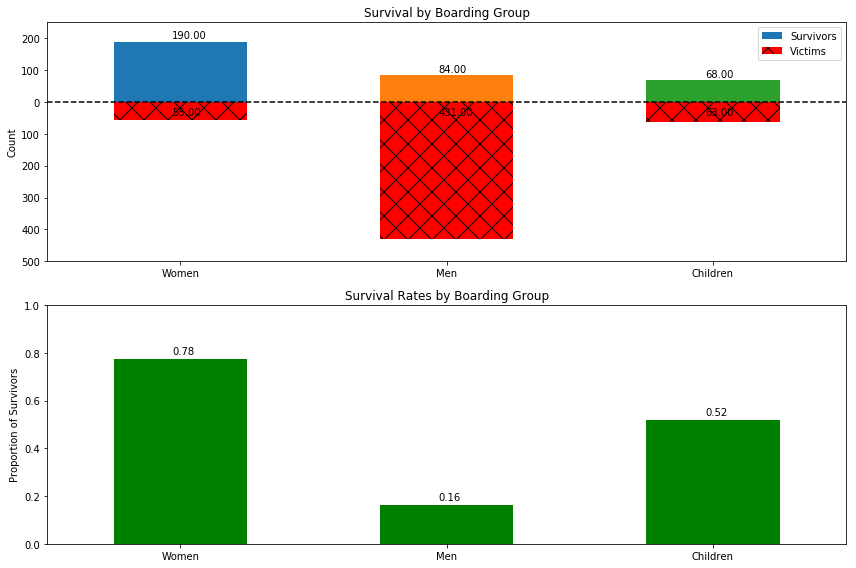

In [65]:
# Plot survival of boarding groups

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize= (12,8))
fig = survivors.plot.bar(ax = ax1)
victims.apply(lambda x: -x).plot.bar(ax= ax1, hatch = 'x', color = 'r')

ax1.legend([ 'Survivors', 'Victims'])
ax1.axhline(0, color = 'k', linestyle = '--')
ax1.set_ylim([-500, 250])
ticks =  ax1.get_yticks()
ax1.set_yticklabels([int(abs(tick)) for tick in ticks])
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation =0)
ax1.set_ylabel('Count')
ax1.set_title('Survival by Boarding Group')

x_offset = -0.03
y_offset = 10
y_drop = -40

for p in [0,1,2]:
    b = ax1.patches[p].get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax1.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

for p in [3,4,5]:
    b = ax1.patches[p].get_bbox()
    val = "{:.2f}".format(abs(b.y1 + b.y0))        
    ax1.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y0 + y_drop))


# Plot survival rates of Women, Men, and Children

survival_rate = data[data.Child == 0].pivot_table('Survived', index = 'Sex', aggfunc = 'mean')
survival_rate.loc['Children']=data[data.Child == 1]['Survived'].mean()
survival_rate = Series(survival_rate.values[:,0], index = ['Women', 'Men', 'Children'], name = 'Group')

survival_rate.plot.bar(ax = ax2, color = 'g')
ax2.set_ylim([0,1])
ax2.set_ylabel('Proportion of Survivors')
ax2.set_title('Survival Rates by Boarding Group')
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation =0)


x_offset = -0.03
y_offset = 0.02
for p in ax2.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax2.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.tight_layout()
plt.show()

Supposing that the lifeboats were filled to capacity, it does appear that men took some seats that could have been occupied by women and children.  As it was, 118 women and children died in our sample.  If the men sacriced their seats, only 34 women or children would have perished.  In fact the men could have made the sacrifice which allowed either all the women or all the children to survive in our sample.  It seems as if the "Women and Children First" protocol was not followed by the 84 men who survived.  Of course the sample does not really tell us why this happened.

Still women and children survived at rates 4.9 and 3.3 times higher than the men so one would expect that this protocol was followed somewhat.  The sample does show a correlation with being a woman or child with survival.

#### Passenger Class and Survival

The variable 'Plcass' had a strong correlation with 'Survival' especially for those in first class and third class.

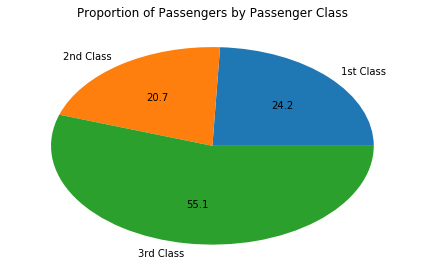

In [66]:
# Plot proportion of 'Pclass' in pie chart

df = None
df = data.pivot_table('PassengerId', index = 'Pclass', aggfunc = 'count')

df.plot.pie(subplots = True, labels = ['1st Class', '2nd Class', '3rd Class'], legend = False, 
           autopct = '%.1f')
plt.title('Proportion of Passengers by Passenger Class')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [67]:
data[['Survived', 'Pclass']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [68]:
# Survival rate of 1st class vs. 3rd
data[data.Pclass ==1].Survived.mean()/data[data.Pclass==3].Survived.mean()

2.597883597883598

In [69]:
# What percentage of victims were in third class
data[data.Survived ==0].Pc3.mean()

0.6775956284153005

From above we see an almost linear relationship between 'Pclass', and the rate of survival.  This translates into first class passengers chance of survival being 2.6 times greater than third class passengers.  Combined with the fact that 55% of passengers were in third class, we find that 68% of the passengers who perished were in third class.

The plot below illustrates that first class males had a higher survival rate than the other males.  We also see how being in third class meant much lower survival rates for both women and children.

In [70]:
# Create dataframes for survivors, victims and survival rate

survivors = DataFrame(columns = np.unique(data.Pclass.values))

survivors = survivors.append(data[data.Woman ==1].pivot_table('Survived', columns = 'Pclass',
                                                             aggfunc = 'sum'))
survivors = survivors.append(data[data.Man ==1].pivot_table('Survived', columns = 'Pclass',
                                                         aggfunc = 'sum'))
survivors = survivors.append(data[data.Child ==1].pivot_table('Survived', columns = 'Pclass',
                                                         aggfunc = 'sum'))
survivors.columns = ['1st Class', '2nd Class', '3rd Class']


survivors.index = ['Women', 'Men', 'Children']

victims = DataFrame(columns = np.unique(data.Pclass.values))
victims = victims.append(data[data.Woman ==1].loc[data.Survived ==0].pivot_table('Survived', columns = 'Pclass',
                                                                               aggfunc = 'count'))
victims = victims.append(data[data.Man ==1].loc[data.Survived ==0].pivot_table('Survived', columns = 'Pclass', 
                                                                           aggfunc = 'count'))
victims = victims.append(data[data.Child ==1].loc[data.Survived ==0].pivot_table('Survived', 
                                                                                  columns = 'Pclass', 
                                                                                  aggfunc = 'count'))
victims.index = ['Women', 'Men', 'Children']

survival_rate = DataFrame(columns = np.unique(data.Pclass.values))
survival_rate = survival_rate.append(data[data.Woman == 1].pivot_table('Survived', columns = 'Pclass',
                                                               aggfunc = 'mean'))
survival_rate = survival_rate.append(data[data.Man == 1].pivot_table('Survived', columns = 'Pclass',
                                                               aggfunc = 'mean'))
survival_rate = survival_rate.append(data[data.Child == 1].pivot_table('Survived', columns = 'Pclass',
                                                                 aggfunc = 'mean'))
survival_rate.columns = ['1st Class', '2nd Class', '3rd Class']
survival_rate.index = ['Women', 'Men', 'Children']


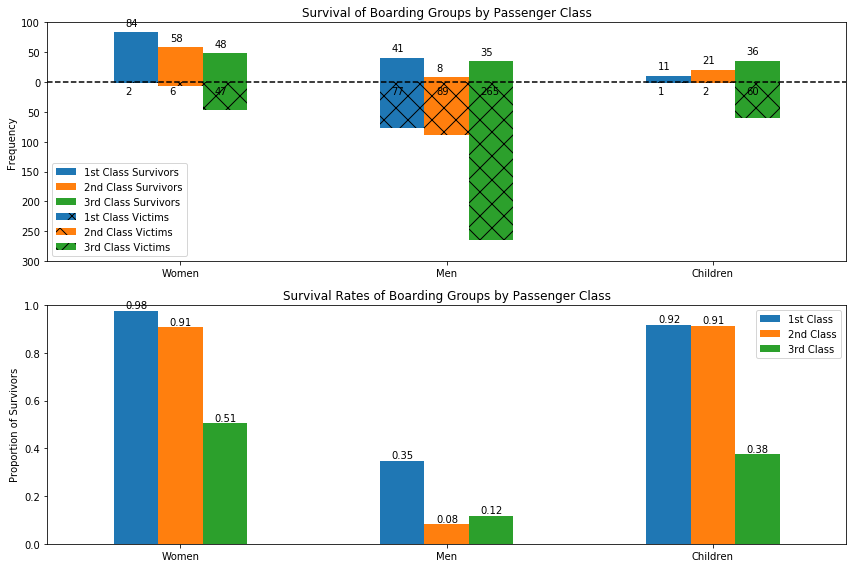

In [71]:
# Plot survival for passenger class and boarding group

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols =1, figsize = (12,8))
fig = survivors.plot.bar(ax = ax1)
victims.apply(lambda x: -1*x).plot.bar(ax = ax1, hatch = 'x')

ax1.legend(['1st Class Survivors', '2nd Class Survivors', '3rd Class Survivors', 
            '1st Class Victims', '2nd Class Victims', '3rd Class Victims'])
ax1.axhline(0, color = 'k', linestyle = '--')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation = 0)
ax1.set_ylabel('Frequency')
ax1.set_ylim([-300, 100])
ticks =  ax1.get_yticks()
ax1.set_yticklabels([int(abs(tick)) for tick in ticks])

ax1.set_title('Survival of Boarding Groups by Passenger Class')

x_offset = -0.04
y_offset = 10
y_drop = -20
for p in np.arange(0,9):
    b = ax1.patches[p].get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    ax1.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

for p in np.arange(9,18):
    b = ax1.patches[p].get_bbox()
    val = "{:.0f}".format(abs(b.y1 + b.y0))        
    ax1.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y0 + y_drop))

# Plot survival rates of Boarding Groups by Passenger Class

survival_rate.plot.bar(ax = ax2)
ax2.set_ylim([0,1])
ax2.set_ylabel('Proportion of Survivors')
ax2.legend()
ax2.set_title('Survival Rates of Boarding Groups by Passenger Class')
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation = 0)

x_offset = -0.04
y_offset = 0.01
for p in ax2.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax2.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.tight_layout()
plt.show()

Another aspect of these plots that is worth considering is how most of the male passengers travelled 3rd class.  Being male has already shown a strong negative correlation with survival so it should be no surprise that 3rd class passengers overall had low survival rates.  However, the fact that 1st class women men and children survived at rates 1.9 to 2.6 times higher than their 3rd class counterparts underscores how 'Pclass' correlates with 'Survived'.

#### Fare Paid and Survival  
There is a positive correlation between 'Fare' and 'Survived'.  I would assume that 'Fare' and 'Pclass' are also positively correlated to eachother which is why they are both positively correlated with 'Survived'.  How strong is this correlation?

Also, does 'Fare' also correlate positively with 'Woman' which we already know has the strongest positive correlation with 'Survived'?

In [72]:
# How does 'Fare' correlate with other variables
data.corr().Fare.sort_values(ascending = False)

Fare           1.000000
Pc1            0.591711
Emb_C          0.269335
Survived       0.257307
Parch          0.216225
Woman          0.194454
Female         0.182333
SibSp          0.159651
Age            0.096067
PassengerId    0.012658
Child         -0.008540
Emb_Q         -0.117216
Pc2           -0.118557
Emb_S         -0.166603
Man           -0.169676
Male          -0.182333
Pc3           -0.413333
Pclass        -0.549500
Name: Fare, dtype: float64

Indeed, 'Fare' does strongly correlate with 'Pclass'.  'Fare' and 'Woman' also have a positive correlation.  This simply means that 1st class passengers and females tended to pay more and it has already been shown that these variables predict survival well.  The fact that 'Fare' correlates with 'Survived' is consistent with what has already been analyzed in the 'Woman', 'Man', 'Child' and 'Pclass' variables.  

What can plotting the 'Fare' illustrate for us?

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


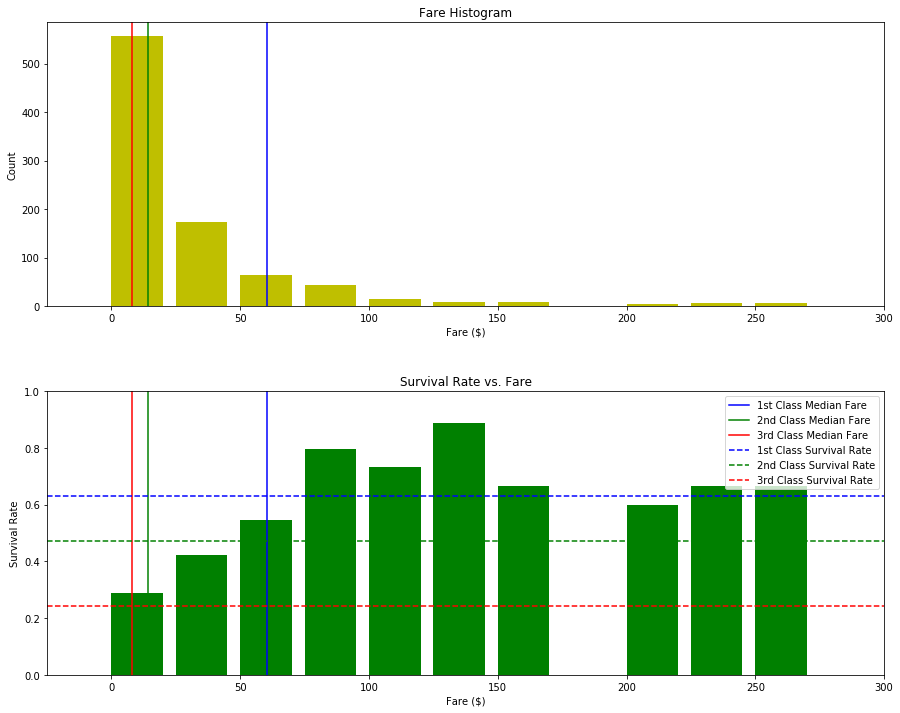

In [73]:
# Plot 'Fare' as a histogram, include median fares for each 'Pclass'

bin_width = 25
lower_bound = -25
upper_bound = 300
bar_width = 20
col_fare = 'y'
col_rate = 'g'
col_c1 = 'b'
col_c2 = 'g'
col_c3 = 'r'


bins = np.arange(lower_bound, upper_bound, bin_width)
index = bins[0:-1]


fig, (ax1, ax2) = plt.subplots(2,1, figsize = (15,12))

ax1.bar(index+0.5*bar_width, np.histogram(data.Fare, bins)[0], 
         width = bar_width, color = col_fare)
ax1.set_xlim(lower_bound, upper_bound)

ax1.axvline(data[data.Pclass == 1].Fare.median(), color = col_c1)
ax1.axvline(data[data.Pclass == 2].Fare.median(), color = col_c2)
ax1.axvline(data[data.Pclass == 3].Fare.median(), color = col_c3)

ax1.set_ylabel('Count')
ax1.set_xlabel('Fare ($)')
ax1.set_title('Fare Histogram')


# Plot fares vs. survival rate, include average survival rate for each 'Pclass'

fare_rate = np.nan_to_num(np.histogram(data[data.Survived ==1].Fare,bins )[0]
                          /np.histogram(data.Fare, bins)[0])


ax2.bar(index+0.5*bar_width, fare_rate, 
        color = col_rate, width = bar_width)
ax2.set_xlim(lower_bound, upper_bound)


ax2.axvline(data[data.Pclass == 1].Fare.median(), color = col_c1)
ax2.axvline(data[data.Pclass == 2].Fare.median(), color = col_c2)
ax2.axvline(data[data.Pclass == 3].Fare.median(), color = col_c3)
ax2.axhline(data[data.Pclass ==1].Survived.mean(), color = col_c1, linestyle = '--')
ax2.axhline(data[data.Pclass ==2].Survived.mean(), color = col_c2, linestyle = '--')
ax2.axhline(data[data.Pclass ==3].Survived.mean(), color = col_c3, linestyle = '--')
ax2.set_ylabel('Survival Rate')
ax2.set_xlabel('Fare ($)')
ax2.set_title('Survival Rate vs. Fare')
ax2.legend(['1st Class Median Fare', 
            '2nd Class Median Fare',
            '3rd Class Median Fare',
            '1st Class Survival Rate',
            '2nd Class Survival Rate',
            '3rd Class Survival Rate'])
ax2.set_ylim(0,1)
plt.subplots_adjust(hspace = .3)
plt.show()


The histograms show how most passengers paid less than $50 dollars for their tickets and this group of passengers had the lowest survival rate.  Passengers who paid more than the median fare for 1st class passengers had the best survival rates though their numbers are few.  

Box plots of the fares paid will give a clearer understanding of what each passenger class paid.  It will also give us a chance to examine how 'Fare' relates to boarding groups.

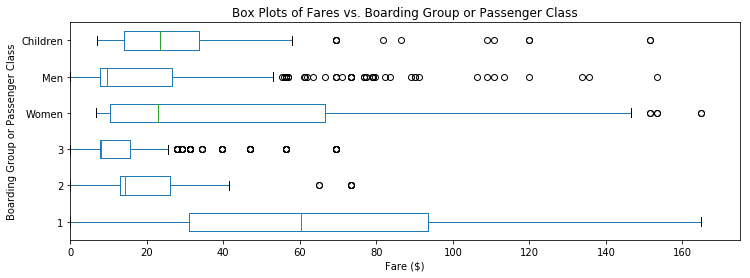

In [74]:
# Box plot 'Fare' for 'Man', 'Woman', 'Child' and 'Pclass'

df = DataFrame(columns = np.unique(data.Pclass.values))
df['Fare'] = data['Fare']
df[1] = data['Fare'].loc[data.Pclass ==1]
df[2] = data['Fare'].loc[data.Pclass ==2]
df[3] = data['Fare'].loc[data.Pclass ==3]
df['Women'] = data['Fare'].loc[data.Woman ==1]
df['Men'] = data['Fare'].loc[data.Man ==1]
df['Children'] = data['Fare'].loc[data.Child==1]
df.drop(['Fare'], axis =1, inplace = True)

fig, ax = plt.subplots(figsize=(12, 4))
fig = df.plot.box(vert = False, ax = ax)
ax.set_xlim([0,175])
ax.set_ylabel('Boarding Group or Passenger Class')
ax.set_xlabel('Fare ($)')
ax.set_title('Box Plots of Fares vs. Boarding Group or Passenger Class')
plt.show()

Now it should be clear how 'Fare' positively correlates with 'Survived'.  'Fare' also has a strong positive correlation to 'Pclass' and 'Woman' which have even stronger correlations with 'Survived'.

#### Summary of factors influencing survival

The table below ranks the survival ranks of all the groups of passengers examined previously.  It also lists what proportion of the overall passengers and victims the group comprised of.  The a group is over or underrepresented in the victim totals is reflected in the 'Death Premium' column which is the proportion that the chance of perishing differs from the sample average.  The 'Death Premium' is simply the proportion of victims divided by the proportion of the sample.

In [75]:
# Summarize survival rates
# Need to learn how to write a function for this

survival_rank = DataFrame(columns = ['Survival Rate', 'Count', 'Proportion Sample', 'Proportion Victims'])
victims = data[data.Survived==0].PassengerId.count()

survival_rank.loc['Ship Total'] = [data.Survived.mean(),
                                     data.Survived.count(),
                                  1,
                                  1]

survival_rank.loc['Women'] = [data['Survived'][data.Woman ==1].mean(),
                              data['Survived'][data.Woman ==1].count(),
                             data.Woman.mean(),
                             data[data.Survived==0].Woman.mean()]

survival_rank.loc['Men'] = [data['Survived'][data.Man == 1].mean(),
                            data['Survived'][data.Man == 1].count(),
                           data.Man.mean(),
                           data[data.Survived==0].Man.mean()]

survival_rank.loc['Children'] = [data['Survived'][data.Child == 1].mean(),
                            data['Survived'][data.Child == 1].count(),
                           data.Child.mean(),
                           data[data.Survived==0].Child.mean()]

survival_rank.loc['First Class'] = [data['Survived'][data.Pc1 ==1].mean(),
                                    data['Survived'][data.Pc1 ==1].count(),
                                   data.Pc1.mean(),
                                   data[data.Survived==0].Pc1.mean()]

survival_rank.loc['Second Class'] = [data['Survived'][data.Pc2 ==1].mean(),
                                    data['Survived'][data.Pc2 ==1].count(),
                                    data.Pc2.mean(),
                                    data[data.Survived==0].Pc2.mean()]

survival_rank.loc['Third Class'] = [data['Survived'][data.Pc3 ==1].mean(),
                                    data['Survived'][data.Pc3 ==1].count(),
                                   data.Pc3.mean(),
                                   data[data.Survived==0].Pc3.mean()]


#survival_rank.sort_values(by = 'Survival Rate', ascending = False)

survival_rank['Death Premium'] = survival_rank['Proportion Victims']/survival_rank['Proportion Sample']-1
survival_rank.sort_values(by = 'Death Premium', ascending = True)

,Survival Rate,Count,Proportion Sample,Proportion Victims,Death Premium
Women,0.775510,245.0,0.274972,0.100182,-0.635664
First Class,0.629630,216.0,0.242424,0.145719,-0.398907
Children,0.519084,131.0,0.147026,0.114754,-0.219497
Second Class,0.472826,184.0,0.206510,0.176685,-0.144423
Ship Total,0.383838,891.0,1.000000,1.000000,0.000000
Third Class,0.242363,491.0,0.551066,0.677596,0.229608
Men,0.163107,515.0,0.578002,0.785064,0.358237


The analysis of non-overlapping variables of the previous sections should have presented a general sense of what variables correlated wtih 'Survival' strongest.  By showing them all together here, we can begin to see the relative strength of correlations with eachother, and how a sample having a certain combination of characteristics might survive or not.

### Conclusions

This investigation began by addressing two nautical expressions:

"Women and Children First" with regard to lifeboat boarding and

"The Captain goes down with the Ship"  

This was a route to examine what variables correlated with survival in the sample of Titanic passengers.  Passengers were seperated into boarding groups: Women, Children and Men.  It was found that the rates of survival were much higher for Women and Children which could lend some credibility to the "Women and Children First" protocol.  During this analysis it was found that gender had a strong correlation with survival with females surviving at higher rates than males as both adults and children.  Overall, women survived at much higher rates than the other boarding groups.

Later passenger class was examined which also had a strong correlation with survival across all boarding groups.  1st Class passengers had a positive correlation with survival and 3rd class passengers a negative correlation.  Women and Children in 1st and 2nd Class seemed to have little trouble boarding lifeboats but their 3rd Class counterparts survived at much lower rates.  Men in 1st class did a little better, but it still appeared that Women and Children got on the lifeboats first.

Finally the fare paid was studied and while paying a higher fare correlated positively with survival, it basically just confirmed that being a 1st class passenger as well as being a woman correlated positively with survival.

One might conclude that the lifeboat boarding protocol aboard the Titanic was "Women and Children First, but not if you are in 3rd Class".  As for the captain of the Titanic, he did indeed "go down with the ship".

Creating boarding groups was difficult because many passengers did not have ages listed.  A few assumptions were made and I think the groups came out well.  However, I did not fill in any of these null values which could have been useful in a machine learning application.

Because of the limits of my statistics knowledge I did not know how to measure statistical significance of categorical data.  This meant that I had to make more general comments about the data and could only state correlations were strong or weak in magnitude.  I was unable to prove any hypothesis using statistical tests.

I wish I was better at using regex functions so that I could extract and more data from the 'Name', 'Cabin', and 'Ticket' variables.  I could for instance create families by matching last names and cabins or ticket numbers.  This could yield more information but I don't feel up to learning how to do this.

### Machine Learning  

Starting off by reloading the data, this time both sets the training and the test set.  Both datasets will be wrangled so that missing values are imputed satisfactorily and desireable features are fed to the machine learning algorithm.  Several algorithms will be tested with perhaps a little hyperparameter tuning.

In [76]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [78]:
print('Training Data')
train.info()
print('-'*20)
print('Test Data')
test.info()

Training Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
--------------------
Test Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-

In [79]:
def create_titles(df):
    regex = re.compile('([A-Za-z]+)\.')
    df['Title'] = df.Name.str.extract(regex, expand = True)
    return df

def create_boarding_groups(df, age_cutoff = 18):
    df['Child'] = (df.Age < age_cutoff).astype(int)
    df['Woman'] = (df[df.Sex == 'female'].Age >= age_cutoff).astype(int)
    df['Man'] = (df[df.Sex == 'male'].Age >= age_cutoff).astype(int)
    df['Woman'] = (df['Woman']).fillna(0)
    df['Man'] = (df['Man']).fillna(0)
    
    mask_m = (df.Age.isnull()) & (df.Title == 'Mr')
    mask_w = (df.Age.isnull()) & (df.Title == 'Mrs')
    mask_c = (df.Age.isnull()) & (df.Title =='Master')
    df.loc[mask_m,'Man'] = 1
    df.loc[mask_w, 'Woman'] =1
    df.loc[mask_c, 'Child'] = 1
    
    mask_m = ((df.Man == 0) & (df.Woman == 0) & (df.Child == 0) & (df.Title != 'Miss') 
          & (df.Sex == 'male'))
    mask_w = ((df.Man == 0) & (df.Woman == 0) & (df.Child == 0) & (df.Title != 'Miss') 
          & (df.Sex == 'female'))
    df.loc[mask_m, 'Man'] = 1
    df.loc[mask_w, 'Woman'] =1
    
    mask_c = (df.Child ==0) & (df.Woman ==0) & (df.Man ==0) & (df.SibSp > 0)
    df.loc[mask_c, 'Child'] =1
    mask_c = (df.Child ==0) & (df.Woman ==0) & (df.Man ==0) & (df.Parch > 0)
    df.loc[mask_c, 'Child'] =1
    
    # Create a mask for solo travelling Miss who are NaN old
    df[df.Man ==0].loc[df.Woman ==0].loc[df.Child==0]
    mask_miss_NaN = (df.Age.isnull()) & (df.Title == 'Miss') & (df.SibSp == 0) & (df.Parch ==0)

    # Assign these passengers to the 'Woman' group
    df.loc[mask_miss_NaN, 'Woman'] = 1

    #print(df['Child'].sum() + df['Woman'].sum() + df['Man'].sum())
    return df

def encode_passenger_class(df):
    # Create new boolean variables for passenger class
    df['Pc1'] = (df['Pclass']==1).astype(int)
    df['Pc2'] = (df['Pclass']==2).astype(int)
    df['Pc3'] = (df['Pclass']==3).astype(int)
    return df

def encode_sex(df):
    # Create new boolean variables for sex
    df['Female'] = (df['Sex']=='female').astype(int)
    df['Male'] = (df['Sex']=='male').astype(int)
    return df


In [80]:
def create_ml_df(df):
    df = create_titles(df)
    df = create_boarding_groups(df)
    df = encode_passenger_class(df)
    df = encode_sex(df)
    df = df.drop(columns=['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 
                        'Cabin', 'Embarked', 'Title'])
    return df

In [83]:
# Load datasets and convert them into machine learning dataframes

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train_df = create_ml_df(train)
test_df = create_ml_df(test)

train_y = train_df['Survived']
train_x = train_df.drop(columns = ['Survived'])

First let us try a logistic regression classifier

In [84]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
from sklearn.model_selection import cross_val_score
lr_scores = cross_val_score(lr_clf, train_x, train_y, cv = 10)
lr_scores.mean()

0.79904579502894113

Now let us try a decision tree classifier

In [88]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(train_x, train_y)
dt_scores = cross_val_score(dt_clf, train_x, train_y, cv = 10)
dt_scores.mean()

0.78006951537850411

Lastly I'll try random forests

In [89]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_scores = cross_val_score(forest_clf, train_x, train_y, cv=10)
forest_scores.mean()

0.78457666553172167

In [90]:
y_predictions = lr_clf.predict(test_df)
submission = pd.DataFrame({
    "PassengerId": test['PassengerId'],
    "Survived": y_predictions
})

submission.to_csv('titanic.csv', index = False)